In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

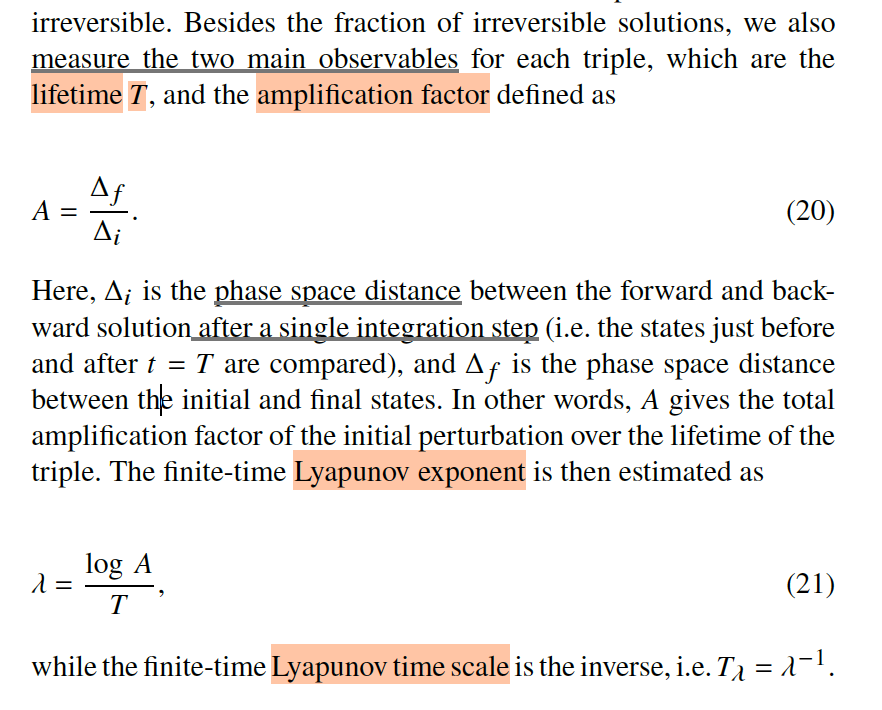

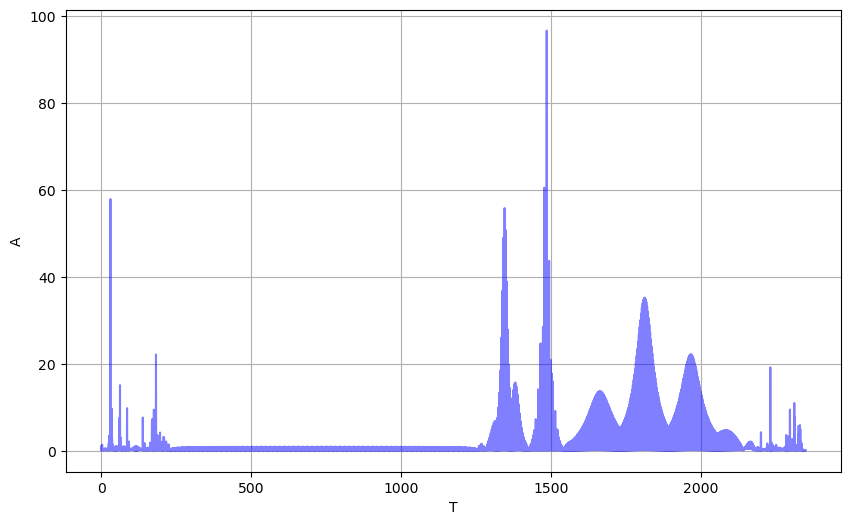

/var/folders/pz/5qchhm2j7nn9jlkwfg3_yckc0000gn/T/ipykernel_89307/2810268874.py:82: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(T_norm), np.log10(np.log10(A)), color='b', alpha=0.5, s=10)
/var/folders/pz/5qchhm2j7nn9jlkwfg3_yckc0000gn/T/ipykernel_89307/2810268874.py:82: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(T_norm), np.log10(np.log10(A)), color='b', alpha=0.5, s=10)


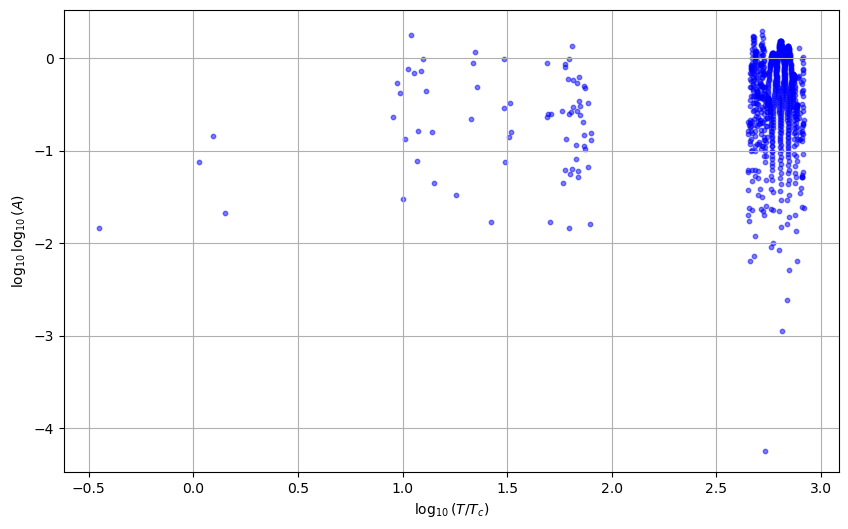

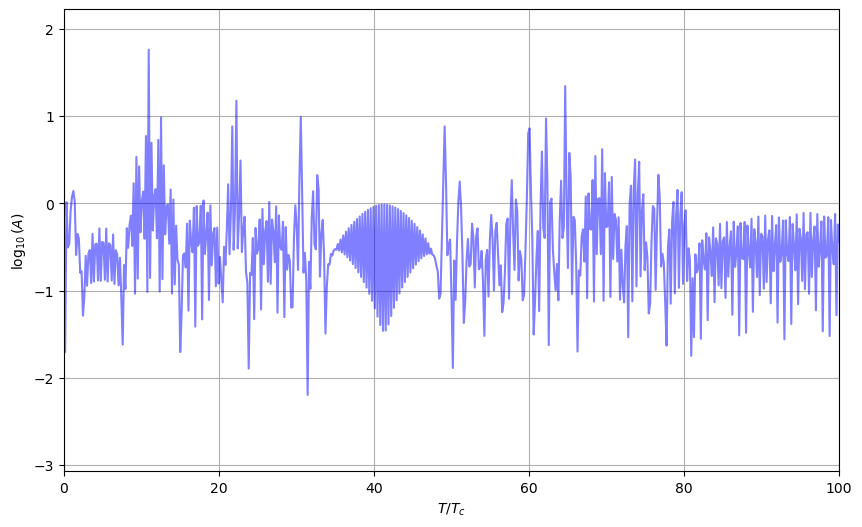

In [62]:
df = pd.read_csv('./Brutus data/plummer_triples_L0_00_i1775_e90_Lw392.csv')

forward_trajectory = df[df['Phase'] == 1]
backward_trajectory = df[df['Phase'] == -1]

total_timesteps = len(df['Timestep'].unique())
midpoint = total_timesteps // 2  # Midpoint corresponds to t=T=lifetime
timesteps = df['Timestep'].unique()

particles = df['Particle Number'].unique()

# Phase space distance between two states
def compute_delta(forward_state, backward_state):
    # Extract positions
    x_f, y_f, z_f = forward_state['X Position'].values, forward_state['Y Position'].values, forward_state['Z Position'].values
    x_b, y_b, z_b = backward_state['X Position'].values, backward_state['Y Position'].values, backward_state['Z Position'].values

    # Extract velocities
    vx_f, vy_f, vz_f = forward_state['X Velocity'].values, forward_state['Y Velocity'].values, forward_state['Z Velocity'].values
    vx_b, vy_b, vz_b = backward_state['X Velocity'].values, backward_state['Y Velocity'].values, backward_state['Z Velocity'].values

    # Compute the phase-space distance for this particle
    diff_vel = (vx_f - vx_b)**2 + (vy_f - vy_b)**2 + (vz_f - vz_b)**2
    diff_pos = (x_f - x_b)**2 + (y_f - y_b)**2 + (z_f - z_b)**2
    
    return np.sum(diff_vel + diff_pos)

# We want to compute delta btw backward and forward solutions at each integration step
# We need to consider the states symetrically around the midpoint
# backward state = total timesteps - 1 - current forward state
# forward state = current forward state (until midpoint)
delta_per_step = []

for i in range(len(timesteps) // 2):
    delta_sum = 0  
    for p in particles:
        forward_p = forward_trajectory[forward_trajectory['Particle Number'] == p]
        backward_p = backward_trajectory[backward_trajectory['Particle Number'] == p]
        
        forward_state = forward_p[forward_p['Timestep'] == timesteps[i]]
        backward_state = backward_p[backward_p['Timestep'] == timesteps[total_timesteps - 1 - i]]
        
        delta = compute_delta(forward_state, backward_state)
        delta_sum += delta
        
    delta_per_step.append(delta_sum)  # Append the delta summed over the bodies for this timestep

# We want to compute delta between initial and final states
delta_initial_final = 0

for p in particles:
    forward_p = forward_trajectory[forward_trajectory['Particle Number'] == p]
    backward_p = backward_trajectory[backward_trajectory['Particle Number'] == p]
    
    # Initial state from forward trajectory
    forward_initial = forward_p[forward_p['Timestep'] == 0]
    
    # Final state from backward trajectory
    max_backward_timestep = backward_p['Timestep'].max()
    backward_final = backward_p[backward_p['Timestep'] == max_backward_timestep]
    
    delta_initial_final += compute_delta(forward_initial, backward_final)

# Amplification factor for each integration step
A = [delta_initial_final/delta_per_step[i] for i in range(len(delta_per_step))]

# Amplification factor evolution over lifetime
plt.figure(figsize=(10, 6))
plt.plot(timesteps[:midpoint],A, color='b', alpha=0.5)
plt.xlabel('T')
plt.ylabel('A')
plt.grid(True)
plt.show()

# Crossing time 
T_c = 2 * np.sqrt(2)
# Normalize lifetime 
T_norm = [timesteps[i] / T_c for i in range(len(delta_per_step))]

# Scatter plot of A vs T/T_c   
plt.figure(figsize=(10, 6))
plt.scatter(np.log10(T_norm), np.log10(np.log10(A)), color='b', alpha=0.5, s=10)
plt.xlabel(r'$\log_{10}(T/T_c)$')
plt.ylabel(r'$\log_{10}\log_{10}(A)$')
plt.grid(True)
plt.show()
# Capire il range di valori, corretto??

# Amplification factor evolution over lifetime
plt.figure(figsize=(10, 6))
plt.plot(T_norm, np.log10(A), color='b', alpha=0.5)
plt.xlabel(r'$T/T_c$')
plt.ylabel(r'$\log_{10}(A)$')
plt.xlim(0, 100)
#plt.ylim(0, 60)
plt.grid(True)
plt.show()

# Metric
# It is the sum of the squared distances between every pair of bodies
# Summed over the three particles
def compute_metric(forward_state, backward_state):
    # Extract positions
    x_f, y_f, z_f = forward_state['X Position'].values, forward_state['Y Position'].values, forward_state['Z Position'].values
    x_b, y_b, z_b = backward_state['X Position'].values, backward_state['Y Position'].values, backward_state['Z Position'].values
    
    # Compute the metric for this particle
    diff = (x_f - x_b)**2 + (y_f - y_b)**2 + (z_f - z_b)**2
    
    return np.sum(diff)

# We want to compute the metric considering squared distances between every pair of bodies

